## Import Dependencies

In [33]:
import numpy as np
import pandas as pd

# tqdm provides responsive progress bars for notebooks.
from tqdm import tqdm_notebook

# For displaying sample images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

# preprocessing
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing import image

# CNN construction
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Transfer Learning
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

# Model Training
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint

# For filesystem operations in saving augmented data to disk
import shutil
import os
import random

# For Model Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools 

# For Prediction
from glob import glob



## Load Data

In [34]:
"""
Loads data from the labeled directory into memory. 
Returns arrays of filenames and target classes.
Note that this doesn't actually load the images into memory.

See http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html 
"""
data = load_files('data/labeled', load_content=False, shuffle=True, random_state=42)

## Display sample images

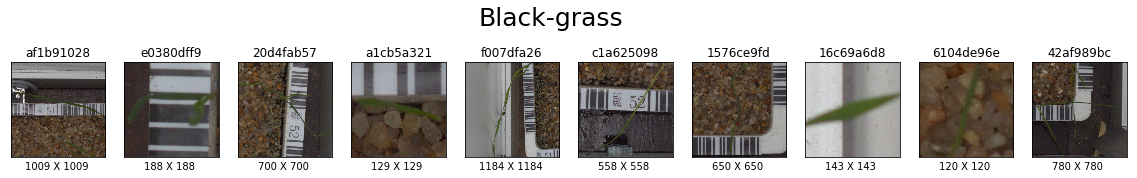

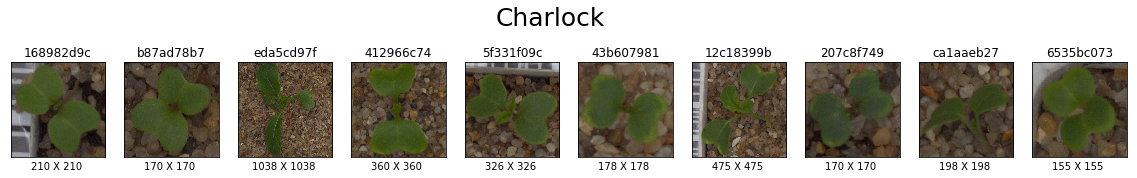

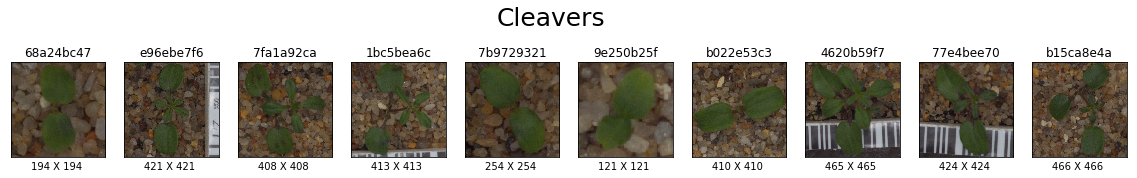

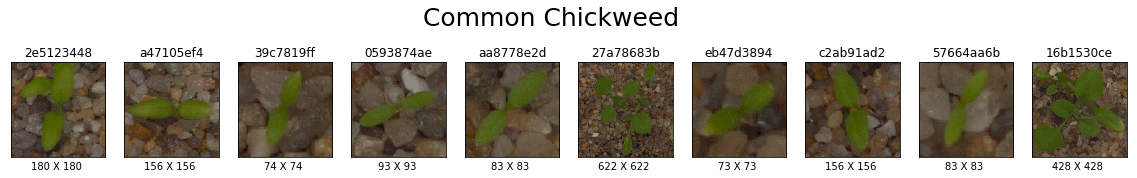

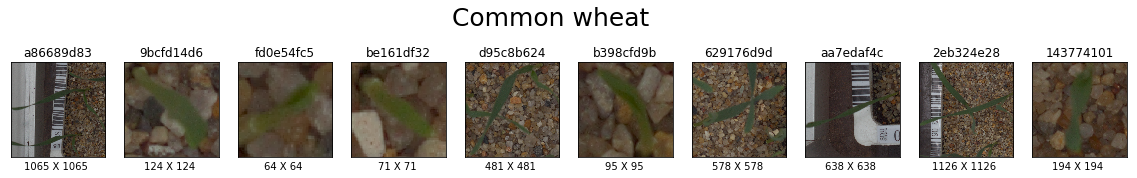

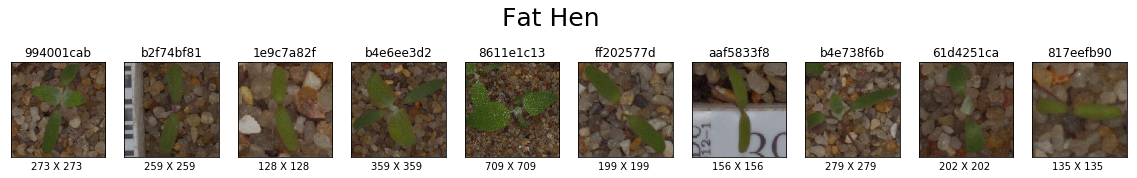

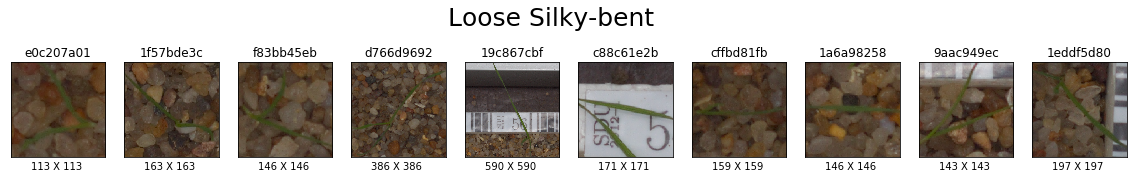

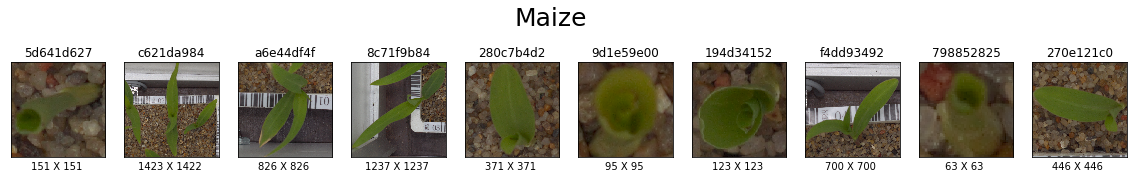

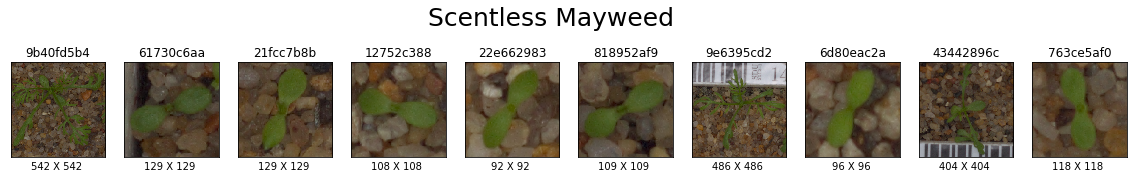

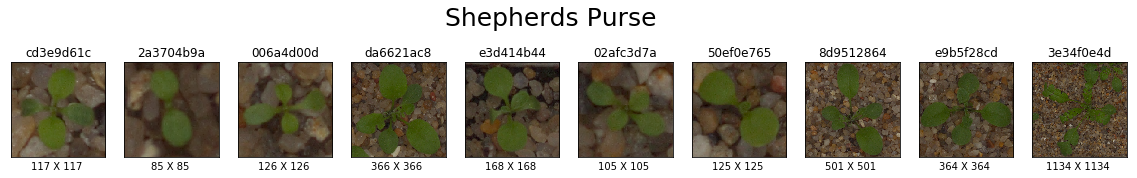

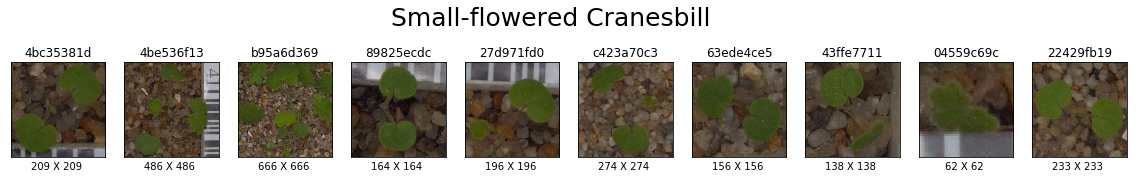

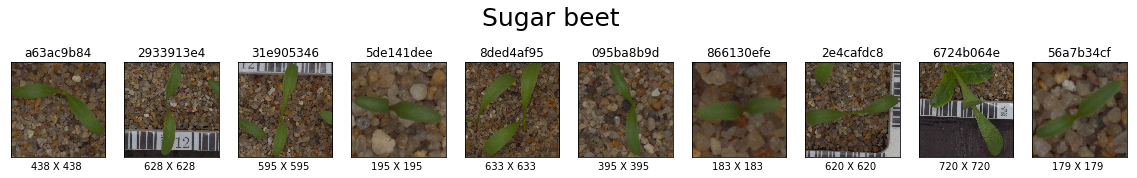

In [35]:
"""
Display 10 samples for each class
Each image's title is its filename. Each image's subtitle is it's height and width in pixels.
"""
def display_image_samples(n=10):
    for seedling_id in range(12):
        fig = plt.figure(figsize=(20,3))
        fig.suptitle(data['target_names'][seedling_id], fontsize=25)
        imgs = [i for i, j in enumerate(data['target']) if j == seedling_id]
        for i in range(n):
            seedling_file = data['filenames'][imgs[i]]
            with Image.open(seedling_file) as img:
                width, height = img.size
                ax = fig.add_subplot(1, n, i+1, xticks=[], yticks=[])
                ax.imshow(mpimg.imread(seedling_file))
                ax.set_title(seedling_file[-13:-4])
                ax.set_xlabel("%d X %d " % (width, height))
        plt.show()

display_image_samples()

## Train Test Split

In [36]:
"""
Splits data into training and testing sets.
"""
def extract_test_and_train(data, perc_test = 0.1):
    x = np.array(data['filenames'])
    y = np.array(data['target'])
    labels = np.array(data['target_names'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=perc_test, random_state=42)
    return x_train, x_test, y_train, y_test, labels

x_train, x_test, y_train, y_test, labels = extract_test_and_train(data)

## Load Training and Test Images into Tensors

In [37]:
"""
Images are loaded into memory and converted into tensors. 
They are all resized to size (224, 224,3). Each is 224px wide by 224px high with 3 RGB color layers. 
Each pixel in the tensor is converted to a scalar value in the range [0,1] by dividing it by 255
"""
def to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0).astype('float32')/255

def to_tensors(img_paths):
    list_of_tensors = [to_tensor(img_path) for img_path in tqdm_notebook(img_paths)]
    return np.vstack(list_of_tensors)

# make tensors from x_train and x_test
x_train_tensors = to_tensors(x_train)
x_test_tensors = to_tensors(x_test)

## One Hot Encode Targets

In [38]:
"""
Targets are one-hot-encoded by converting them from integers to 12-item vectors
"""
y_train_targets = np_utils.to_categorical(y_train, 12)
y_test_targets = np_utils.to_categorical(y_test, 12)


## Plot Class Distribution

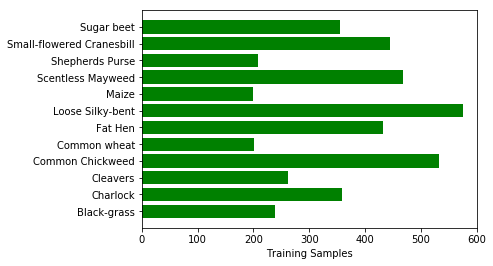

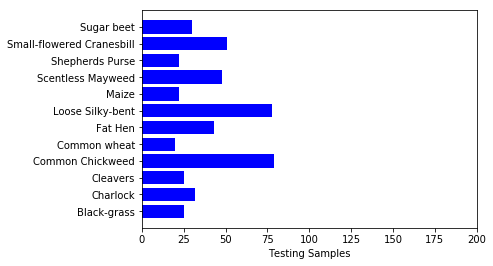

In [39]:
"""
Plot the distribution of samples across 12 classes
"""
def plot_class_distribution(targets, title, xlim, bar_color, labels):
    fig, ax = plt.subplots()
    y_pos = np.arange(len(labels))
    train_labels = np.sum(targets, axis=0)
    ax.barh(y_pos, train_labels, align='center', color=bar_color)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel(title)
    ax.set_xlim(0, xlim)
    plt.show()

    
plot_class_distribution(y_train_targets, 'Training Samples', 600, 'green', labels)
plot_class_distribution(y_test_targets, 'Testing Samples', 200, 'blue', labels)

## Augment and Oversample Training Data

In [40]:
"""
Creates 2000 Augmented Training Images for each class. These are saved to the data/augmented folder.
"""
datagen = image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def augment_and_oversample(x_train_tensors, y_train, labels, n = 2000):
    # empty the augmented folder
    if os.path.isdir('data/augmented'): 
        shutil.rmtree('data/augmented')
    os.makedirs('data/augmented')
    # for each of the unique seedling ids
    for seedling_id in range(12):
        # create a folder in augmented for the seedling
        print('Augmenting training data for %s' % labels[seedling_id])
        directory_for_images = 'data/augmented/%s' % labels[seedling_id]
        os.makedirs(directory_for_images)
        imgs = [i for i, j in enumerate(y_train) if j == seedling_id]
        random.shuffle(imgs)
        # pad imgs list to be of length n
        imgs = (imgs * (n // len(imgs))) + imgs[0:n % len(imgs)]        
        # create n new tensors, iterating through all the matching tensors in x_train
        n_imgs = x_train_tensors[imgs]
        for batch in datagen.flow(n_imgs, batch_size=n, save_to_dir=directory_for_images, save_format='png'):
            break

# Once the augmented data is created, it's not necessary to recreate it again. 

# The next line is commented out to avoid unnecessarily recreating the augmented data which takes ~ 30 minutes

#augment_and_oversample(x_train_tensors, y_train, labels)

## Load Augmented Images into Tensors

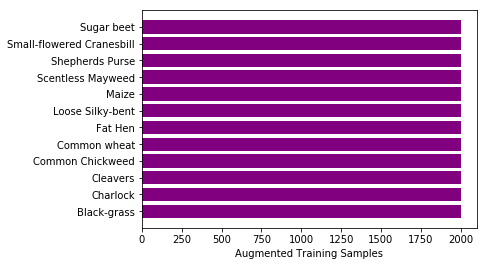

In [41]:
"""
Augmented Images are loaded into memory and converted into tensors. 
"""
data_augmented = load_files('data/augmented', load_content=False, shuffle=True, random_state=42)
x_augmented = np.array(data_augmented['filenames'])
x_augmented_tensors = to_tensors(x_augmented)
y_augmented = np.array(data_augmented['target'])

# One hot encode the targets
y_augmented_targets = np_utils.to_categorical(y_augmented, 12)

# Plot class distribution
plot_class_distribution(y_augmented_targets, 'Augmented Training Samples', 2100, 'purple', labels)

## Define F1 Score for Training in Keras

In [42]:
"""
Keras does not offer F1 Score as built-in metrics function a F1 Score as metric for training in keras. 
As a result F1 Score is provided as a custom metric.

More Information: https://keras.io/metrics/
Code source: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
"""
# 
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

## Compile basic CNN from scratch

In [43]:
"""
Compile 14-layer CNN from scratch
"""
basic_cnn = Sequential()
basic_cnn.name = 'basic_cnn'

### TODO: Define your architecture.
basic_cnn.add(Conv2D(16, kernel_size=2, strides=1, input_shape=(224,224,3)))
basic_cnn.add(MaxPooling2D(pool_size=2))
basic_cnn.add(Conv2D(32, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))
basic_cnn.add(Conv2D(64, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

# Added these two layers to the hinted solution
basic_cnn.add(Conv2D(128, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

# Added additional layers to the hinted solution
basic_cnn.add(Conv2D(256, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

# Added additional layers to the hinted solution
basic_cnn.add(Conv2D(512, kernel_size=2, strides=1))
basic_cnn.add(MaxPooling2D(pool_size=2))

basic_cnn.add(GlobalAveragePooling2D())
basic_cnn.add(Dense(12, activation='softmax'))
basic_cnn.summary()

basic_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_307 (Conv2D)          (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_309 (Conv2D)          (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_310 (Conv2D)          (None, 26, 26, 128)       32896     
__________

## Compile new CNN based on VGG 19 using Transfer Learning

In [44]:
"""
Import VGG19. Freeze the first 5 layers and retrain the remaining layers. 
Add a final layer with 12 nodes to predict the seedling species.
"""
last_layer_to_freeze = 10

vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

# freeze all the existing layers
for layer in vgg_model.layers[:last_layer_to_freeze]:
   layer.trainable = False

# adding custom Layers 
x = vgg_model.output
x = Flatten()(x)
predictions = Dense(12, activation='softmax')(x)

# creating the final model 
vgg_based_cnn = Model(input = vgg_model.input, output = predictions)
vgg_based_cnn.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[f1])
vgg_based_cnn.name = 'vgg_based_cnn'

/home/sgreenberg/anaconda3/envs/seedlings/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## Compile new CNN based on Inception V3 using Transfer Learning

In [45]:
"""
Import Inception V3. Freeze the first 50 layers and retrain the remaining layers. 
Add a final layer with 12 nodes to predict the seedling species.
"""
last_layer_to_freeze = 200

inception_v3 = InceptionV3(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

# freeze all the existing layers
for layer in inception_v3.layers[:last_layer_to_freeze]:
   layer.trainable = False

# adding custom Layers 
x = inception_v3.output
x = Flatten()(x)
predictions = Dense(12, activation='softmax')(x)

# creating the final model 
inception_based_cnn = Model(input = inception_v3.input, output = predictions)

inception_based_cnn.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[f1])
inception_based_cnn.name = 'inception_based_cnn'

/home/sgreenberg/anaconda3/envs/seedlings/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## Define Confusion Matrix Plot

In [46]:
"""
Neither scikit-learn nor keras offer a built-in confusion matrix with readable formatting. 
This function fills that need.

Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Train the CNN

In [47]:
"""
Train a model. 

The best model definition and weights are saved out to an hdf5 file with the model's name.

Parameters:
 - model - The compiled model to train.
 - epochs - Training is run for a series of epochs. Each epoch covers the entire training dataset.
 - x defaults to x_training_tensors, but can optionally be set to x_augmented_tensors.
 - y defaults to y_training_targets, but can optionally be set to y_augmented_targets.
 - validate_using_test_set. Two options for validation in the training loop: 
   - True: Validation uses the same test set that's also used in the evaluation step below.
   - False: 20% of the training data can be withheld for validation.
"""
def train(model, epochs=5, x=x_train_tensors, y=y_train_targets, validate_using_test_set = True):
    checkpointer = ModelCheckpoint(filepath="saved_models/weights.best.from_%s.hdf5" % model.name, 
                               verbose=1, save_best_only=True)
    if validate_using_test_set:
        model.fit(x, y, 
              validation_data=(x_test_tensors, y_test_targets),
              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
    else:
        model.fit(x, y, 
              validation_split=0.2, shuffle=True,
              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
        
    



## Evaluate Results

In [48]:
"""
Evaluate the results of a model.
The F1 Score for the Test Sample is displayed. 
A confusion matrix showing all True Positives, False Negatives and False Positives is displayed. 
"""
def evaluate(model):
    model.load_weights("saved_models/weights.best.from_%s.hdf5" % model.name)
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test_tensors]
    y_true = np.argmax(y_test_targets, axis=1)

    f1 = f1_score(y_true, y_pred, average='micro')
    print('Test F1 Score: %.5f' % f1)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion matrix')
    plt.show()


## Create predictions to submit to Kaggle

In [49]:
"""
Load the unlabeled examples provided by kaggle. 
Create predictions using the model and save these out to a csv that can be submitted to Kaggle.
Note that the column header (first line of the file) needs to be changed to "file,species" in order to submit.
"""
def predict(model):
    unlabeled_files = glob("data/unlabeled/*")
    unlabeled_tensors = to_tensors(unlabeled_files)
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in unlabeled_tensors]

    file_names = [x[15:] for x in unlabeled_files]
    df = pd.DataFrame(index=file_names, data=labels[predictions])
    df.to_csv("predictions/predictions_from_%s.csv" % model.name)

## Choose model, train, evaluate and predict

Train on 4275 samples, validate on 475 samples
Epoch 1/10
4275/4275 [==============================] - 22s - loss: 2.0456 - f1: nan - val_loss: 1.5934 - val_f1: 0.3982
Epoch 2/10
4275/4275 [==============================] - 16s - loss: 1.4615 - f1: nan - val_loss: 1.1422 - val_f1: 0.5171
Epoch 3/10
4275/4275 [==============================] - 16s - loss: 1.1729 - f1: 0.5481 - val_loss: 1.0946 - val_f1: 0.6012
Epoch 4/10
4275/4275 [==============================] - 16s - loss: 0.9487 - f1: 0.6632 - val_loss: 0.8171 - val_f1: 0.7031
Epoch 5/10
4275/4275 [==============================] - 16s - loss: 0.7869 - f1: 0.7261 - val_loss: 0.5849 - val_f1: 0.7941
Epoch 6/10
4275/4275 [==============================] - 16s - loss: 0.6807 - f1: 0.7753 - val_loss: 0.6113 - val_f1: 0.7652
Epoch 7/10
4275/4275 [==============================] - 16s - loss: 0.5857 - f1: 0.8043 - val_loss: 0.8292 - val_f1: 0.7099
Epoch 8/10
4275/4275 [==============================] - 16s - loss: 0.5060 - f1: 0.8331 - v

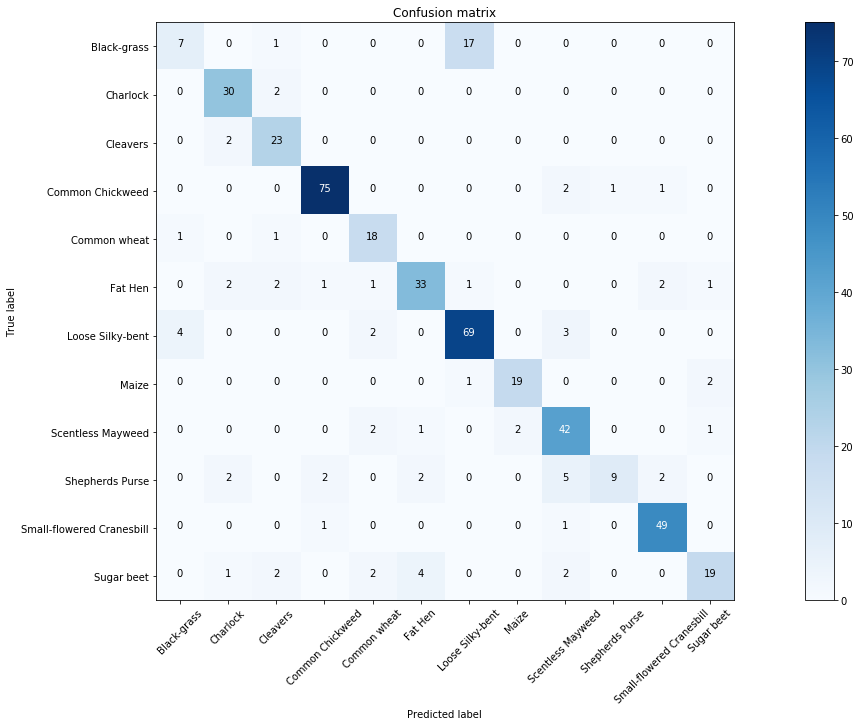

In [50]:
"""
This cell calls the train, evaluate and predict functions.
Uncomment the desired model line and set the desired number of epochs before running.
"""
model = basic_cnn
#model = vgg_based_cnn
#model = inception_based_cnn

n_epochs = 10

train(model, epochs=n_epochs, validate_using_test_set=True)
#train(model, epochs=n_epochs, validate_using_test_set=False, x = x_augmented_tensors, y = y_augmented_targets)
evaluate(model)
predict(model)


## Evaluate against data from the wild


Test F1 Score: 0.03125


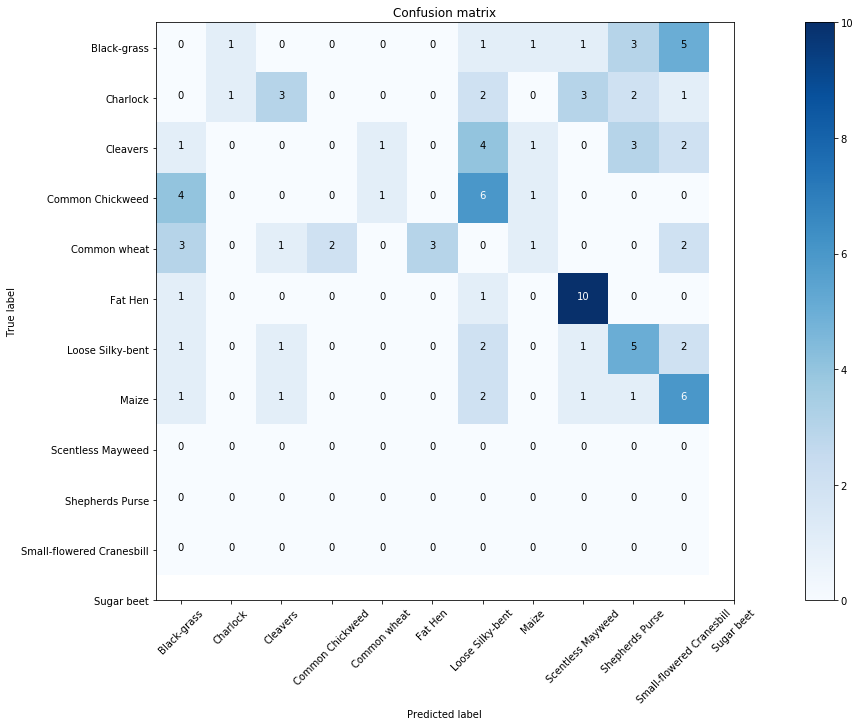

In [28]:
"""
Loads pictures of seedlings taken from the wild and predicts their class. F1 Score and Confusion Matrix are
printed for these new pictures.
"""
def evaluate_with_wild_data(model):
    model.load_weights("saved_models/weights.best.from_%s.hdf5" % model.name)
    
    data_wild = load_files('data/from_the_wild', load_content=False, shuffle=True, random_state=42)
    x_wild = np.array(data_wild['filenames'])
    x_wild_tensors = to_tensors(x_wild)
    y_wild = np.array(data_wild['target'])

    # One hot encode the targets
    y_wild_targets = np_utils.to_categorical(y_wild, 12)
    
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_wild_tensors]
    y_true = np.argmax(y_wild_targets, axis=1)

    f1 = f1_score(y_true, y_pred, average='micro')
    print('Test F1 Score: %.5f' % f1)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion matrix')
    plt.show()
    
    
evaluate_with_wild_data(inception_based_cnn)

## Image Size Distribution per class

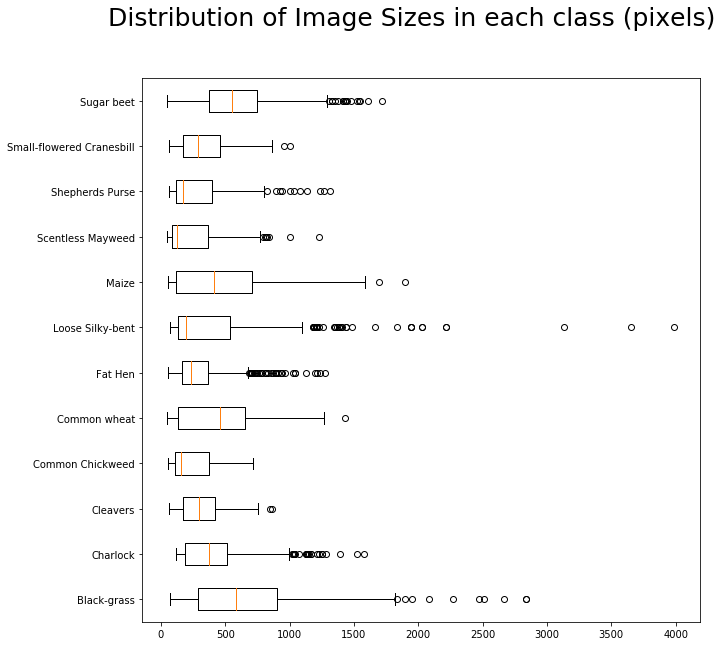

In [36]:
"""
Displays a boxplot showing the distribution of image sizes for each class.
Because each image is a square, we only need to plot the width. 
The median image width for each class is shown by an orange line. The box shows the 25th to 75th percentile of data. 
Whiskers show the extent of the data - not including outliers. 
Outliers (defined as those points more than 1.5x the Inner Quartile Range below the 25th or above the 75th percentile)
are shown with circles. 
"""
def display_image_size_distribution():
    widths_for_each_class = []
    for seedling_id in range(12):
        imgs = [i for i, j in enumerate(data['target']) if j == seedling_id]
        widths = [Image.open(data['filenames'][i]).width for i in imgs]
        widths_for_each_class.append(widths)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Distribution of Image Sizes in each class (pixels)", fontsize=25)
    plt.boxplot(widths_for_each_class, vert=False, labels=data['target_names'])
    plt.show()

display_image_size_distribution()